    # Automatic Jupyter Notebook for OpenML dataset 150: covertype

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import openml as oml
import numpy as np
import pandas as pd
from sklearn import dummy
from sklearn.model_selection import train_test_split
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 

from preamble import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pymongo import MongoClient

Calculate baseline accuracy using scikit-learn DummyClassifier. 

In [2]:
def baseline(data):
    strategies = ['stratified','most_frequent','prior','uniform']
    baseDict = {}
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for strat in strategies:
        clf = dummy.DummyClassifier(strategy=strat,random_state=0)
        clf.fit(X_train, y_train)
        baseDict[strat] = clf.score(X_test, y_test)
    return baseDict  

Generates a plot of the baseline accuracy of the various baseline strategies using scikit-learn DummyClassifier.


In [3]:
def plot_baseline(scores):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple

    strats = scores
    maxBaseline = strats[max(strats, key=strats.get)]
    
    n_groups = len(strats)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    plt.bar(range(len(strats)), strats.values(), align='center')
    plt.xticks(range(len(strats)), list(strats.keys()))
    plt.yticks(np.arange(0, 1.1, step=0.2))
    plt.yticks(list(plt.yticks()[0]) + [maxBaseline])

    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=1)
    ax.set_xlabel('Baseline Strategy')
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performance Predicting Feature: ' + data.default_target_attribute)
    plt.axhline(y=maxBaseline, color='r', linestyle='--', label=maxBaseline)
    plt.gca().get_yticklabels()[6].set_color('red')
    fig.tight_layout()
    plt.show() 

Build Random Forest model from the dataset and compute important features. 

In [4]:
def build_forest(data):    
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    forest = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                       ('classifiers', RandomForestClassifier(n_estimators=100, random_state=0))])
    forest.fit(X,y)
    
    importances = forest.steps[1][1].feature_importances_
    indices = np.argsort(importances)[::-1]
    return data.name, features, importances, indices 

Plot Top-20 important features for the dataset. 

In [5]:
def plot_feature_importances(features, importances, indices):
    a = 0.8
    f_sub = []
    max_features = 20

    for f in range(min(len(features), max_features)): 
            f_sub.append(f)

    # Create a figure of given size
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    # Set title
    ttl = dataset_name

    df = pd.DataFrame(importances[indices[f_sub]][::-1])
    df.plot(kind='barh', ax=ax, alpha=a, legend=False, edgecolor='w', 
            title=ttl, color = [plt.cm.viridis(np.arange(len(df))*10)])

    # Remove grid lines and plot frame
    ax.grid(False)
    ax.set_frame_on(False)

    # Customize title
    ax.set_title(ax.get_title(), fontsize=14, alpha=a, ha='left', x=0, y=1.0)
    plt.subplots_adjust(top=0.9)

    # Customize x tick lables
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.locator_params(axis='x', tight=True, nbins=5)

    # Customize y tick labels
    yticks = np.array(features)[indices[f_sub]][::-1]
    ax.set_yticklabels(yticks, fontsize=8, alpha=a)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_ticks_position('none')  
    ax.set_ylim(ax.get_ylim()[0]-0.5, ax.get_ylim()[1]+0.5) 

    # Set x axis text
    xlab = 'Feature importance'
    ax.set_xlabel(xlab, fontsize=10, alpha=a)
    ax.xaxis.set_label_coords(0.5, -0.1)

    # Set y axis text
    ylab = 'Feature'
    ax.set_ylabel(ylab, fontsize=10, alpha=a)
    plt.show() 

Choose desired dataset and generate the most important plot. 

In [6]:
dataset = 150

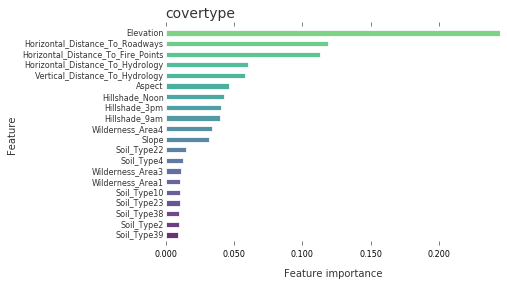

In [7]:
data = oml.datasets.get_dataset(dataset)
dataset_name, features, importances, indices = build_forest(data)
plot_feature_importances(features, importances, indices)

Plot of the baseline acuracy of the various baseline strategies using scikit-learn DummyClassifier.

The target feature is: **class**

The following baseline strategies are used: stratified, most_frequent, prior, uniform.

The strategies work as follow according to the sciki-learn API:

- **stratified**: Generates predictions by respecting the training set’s class distribution.

- **most_frequent**: Always predicts the most frequent label in the training set. Also known as ZeroR.

- **prior**: Always predicts the class that maximizes the class prior. 

- **uniform**: Generates predictions uniformly at random.

The horizontal red dotted line denotes the baseline value for this dataset which is equal to the best performing baseline strategy.

[More information.](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)


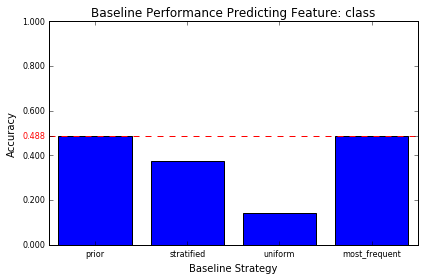

In [8]:
plot_baseline(baseline(data))
